In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

plt.style.use('seaborn')

In [2]:
data_path = '../../../Lectures/Lecture 3/data/hw3.csv'

data_df = pd.read_csv(data_path)
data_df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [3]:
data_df.sort_values('ts', inplace=True)
data_df.reset_index(drop=True, inplace=True)
data_df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-01 00:00:00,210.3120,NaN,208.4320,208.6760,70031.618000,NaN,SOL,SOL
1,2021-12-01 00:00:00,280.5900,281.4000,278.3000,278.7000,207.849000,NaN,COMP,ETH
2,2021-12-01 00:00:00,257.1020,260.7750,255.3450,257.0780,2730.299000,NaN,AAVE,ETH
3,2021-12-01 00:00:00,21.2004,21.3115,21.0337,21.2659,12406.133674,NaN,UNI,ETH
4,2021-12-01 00:00:00,57321.4100,57451.0500,56814.3400,56987.9700,388.482022,NaN,BTC,BTC


# Clean data

In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


## Formatting the token names

In [5]:
data_df.token.unique()

array(['SOL', 'COMP', 'AAVE', 'UNI', 'BTC', 'ETH', 'USDT', 'CRV',
       '<span name="tokenName">SOL</span>',
       '<span name="tokenName">ETH</span>',
       '<span name="tokenName">USDT</span>',
       '<span name="tokenName">UNI</span>',
       '<span name="tokenName">BTC</span>',
       '<span name="tokenName">CRV</span>',
       '<span name="tokenName">AAVE</span>',
       '<span name="tokenName">COMP</span>'], dtype=object)

In [6]:
data_df.loc[data_df.token.str.contains('span'), 'token'] = data_df.loc[data_df.token.str.contains('span'), 'token'].str.extract('<span name="tokenName">(.*?)<\/span>').values

In [7]:
data_df.token.unique()

array(['SOL', 'COMP', 'AAVE', 'UNI', 'BTC', 'ETH', 'USDT', 'CRV'],
      dtype=object)

In [8]:
data_df.token.value_counts()

UNI     342
BTC     337
CRV     335
SOL     334
USDT    333
COMP    332
AAVE    328
ETH     326
Name: token, dtype: int64

In [9]:
data_df.token.value_counts().sum() == data_df.shape[0]

True

## Drop duplicates

In [10]:
data_df.drop_duplicates(subset=['ts','chain','token'], inplace=True)

## Replace outliers

In [11]:
def price_plotting(data_df, price_name):
    df = data_df.copy()
    df.set_index('ts', inplace=True)
    n_tokens = len(df.token.unique())
    fig, axes = plt.subplots(nrows=math.ceil(n_tokens/2), ncols=2,
                             figsize=(15, 5*math.ceil(n_tokens/2)))

    for i, (token, token_df) in enumerate(df[['token',price_name]].groupby('token')):
        token_df[price_name].plot(ax=axes[i//2, i%2], label=token, rot=45)
        axes[i//2, i%2].legend()
        
    plt.suptitle(f'{price_name} price of each token', fontsize=16, y=1)
    plt.tight_layout()

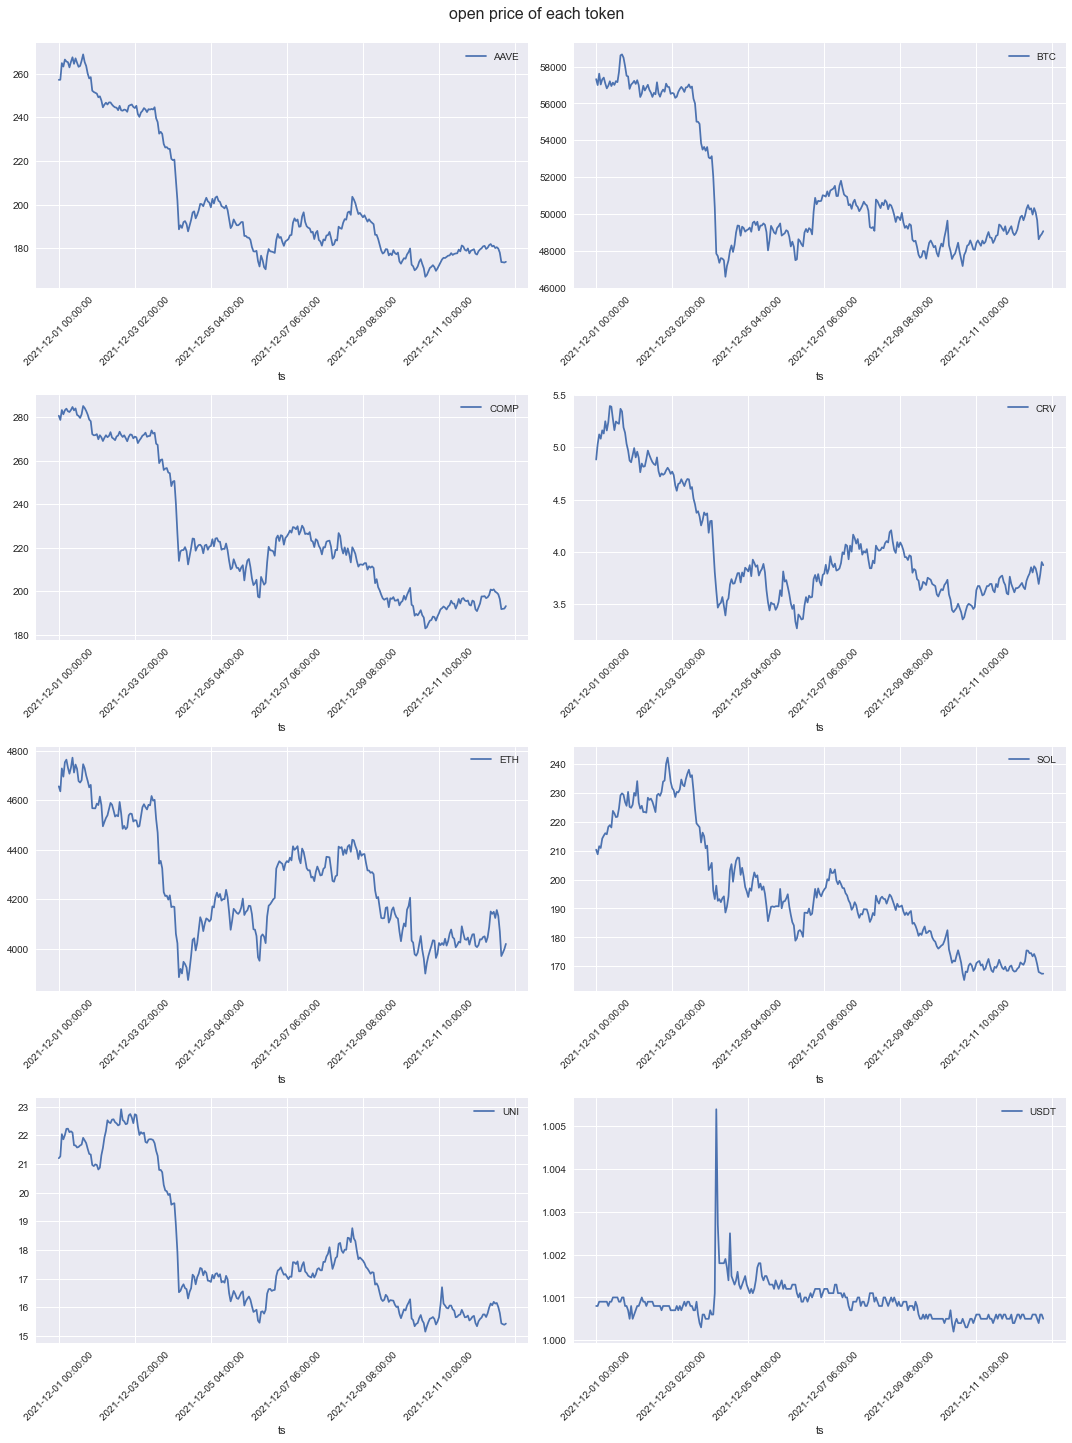

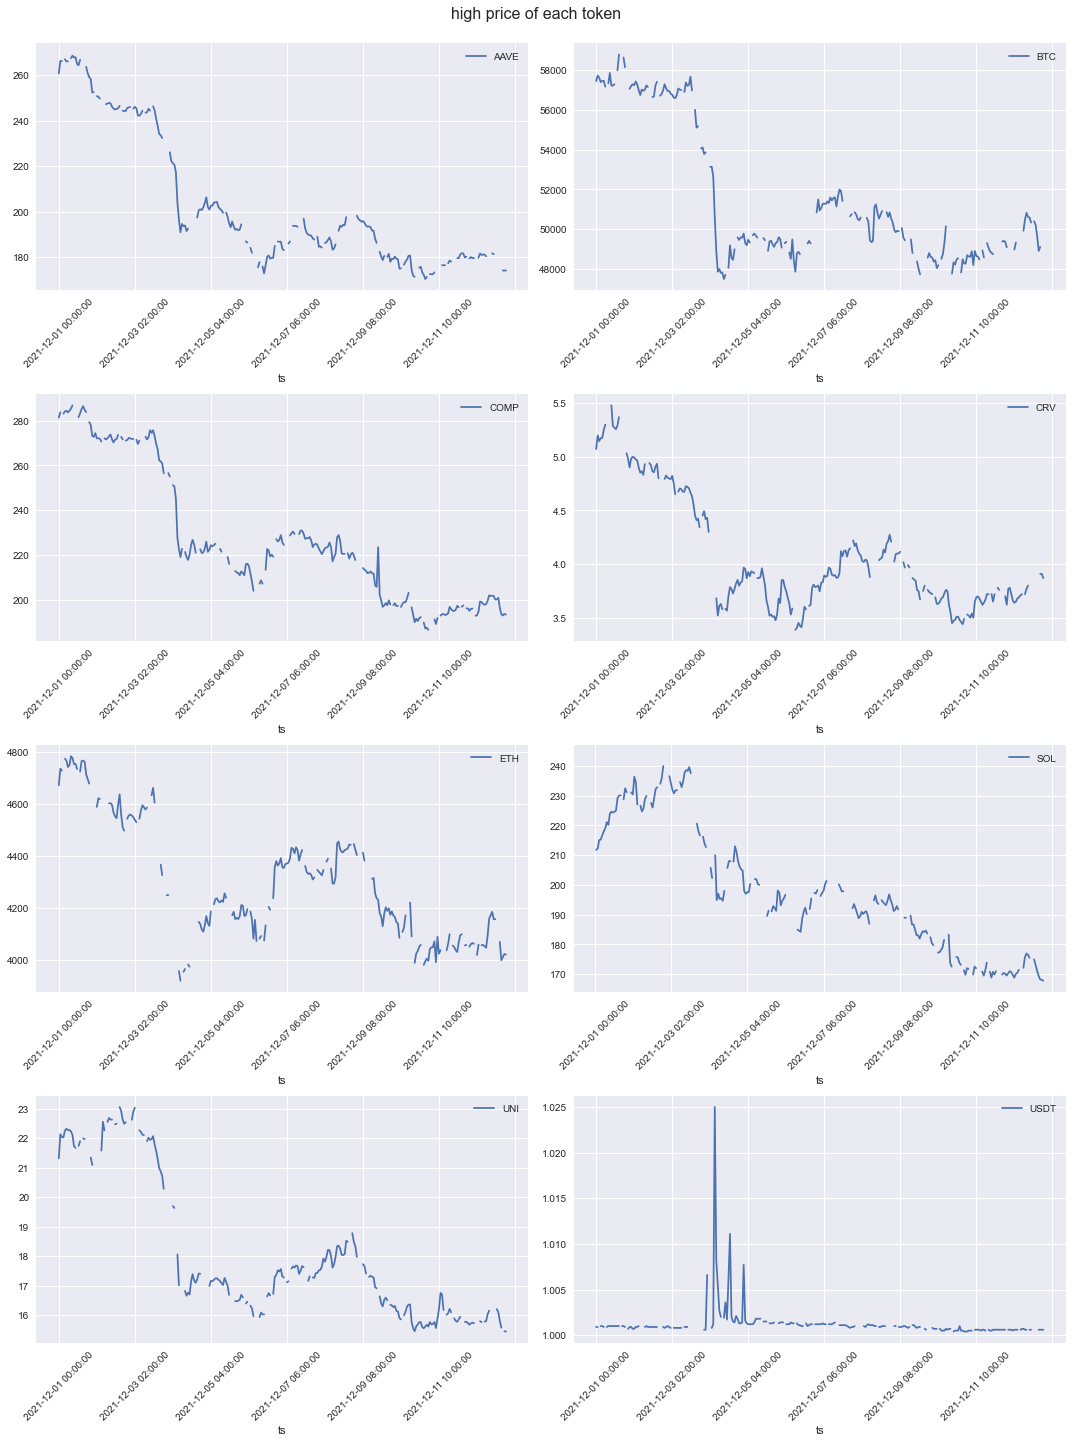

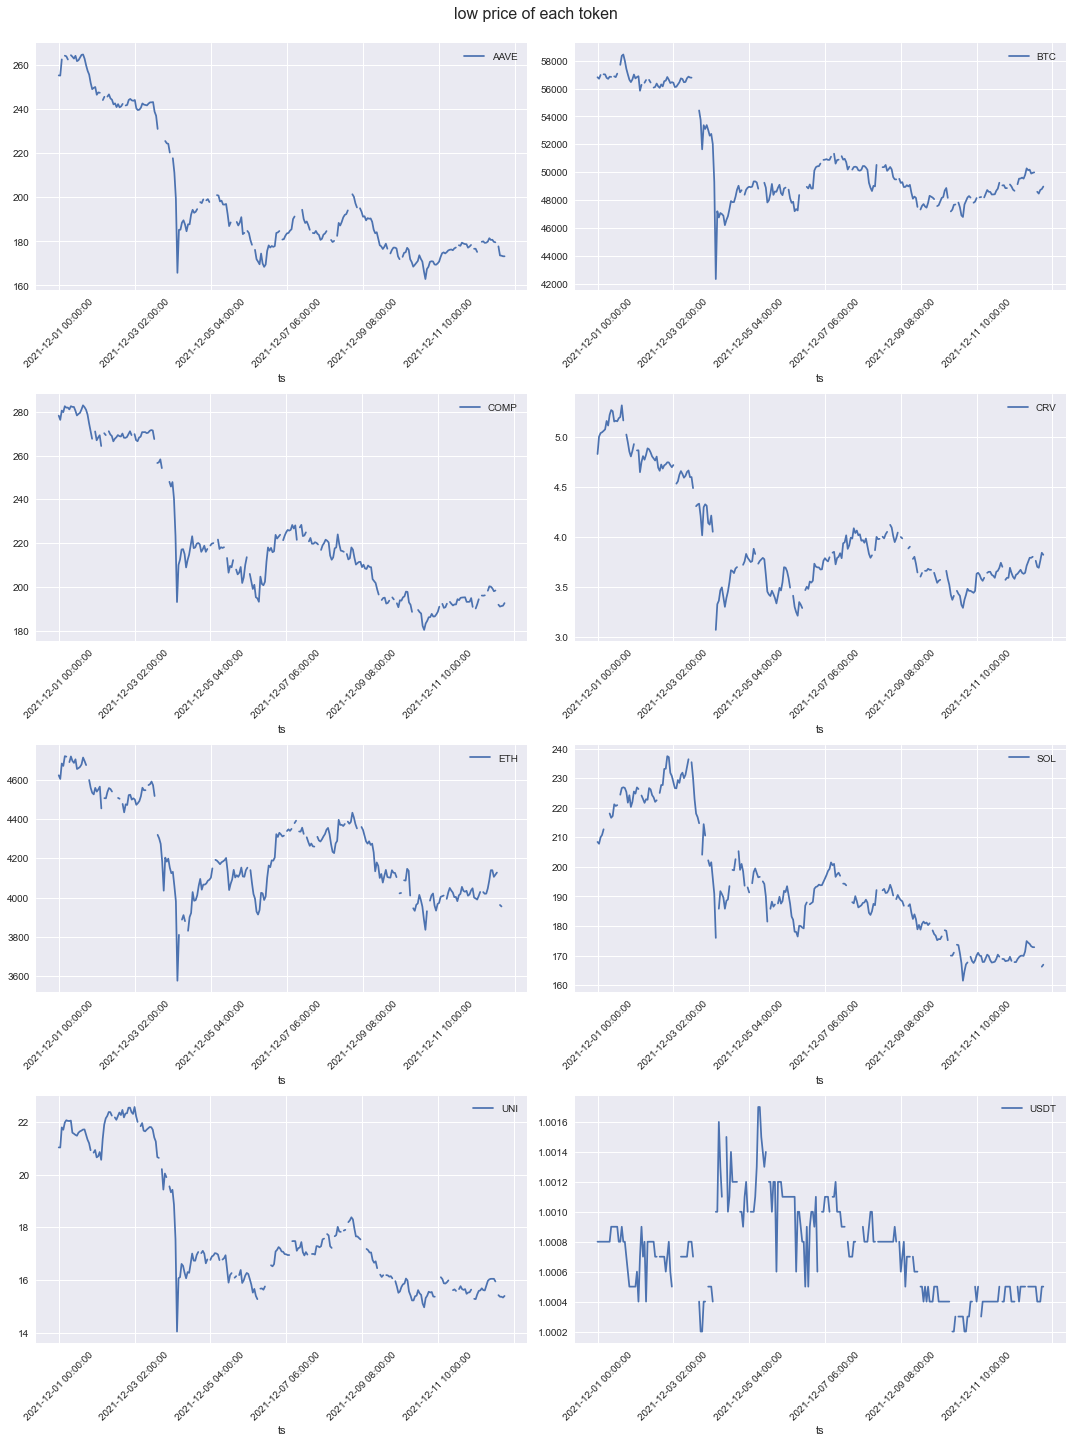

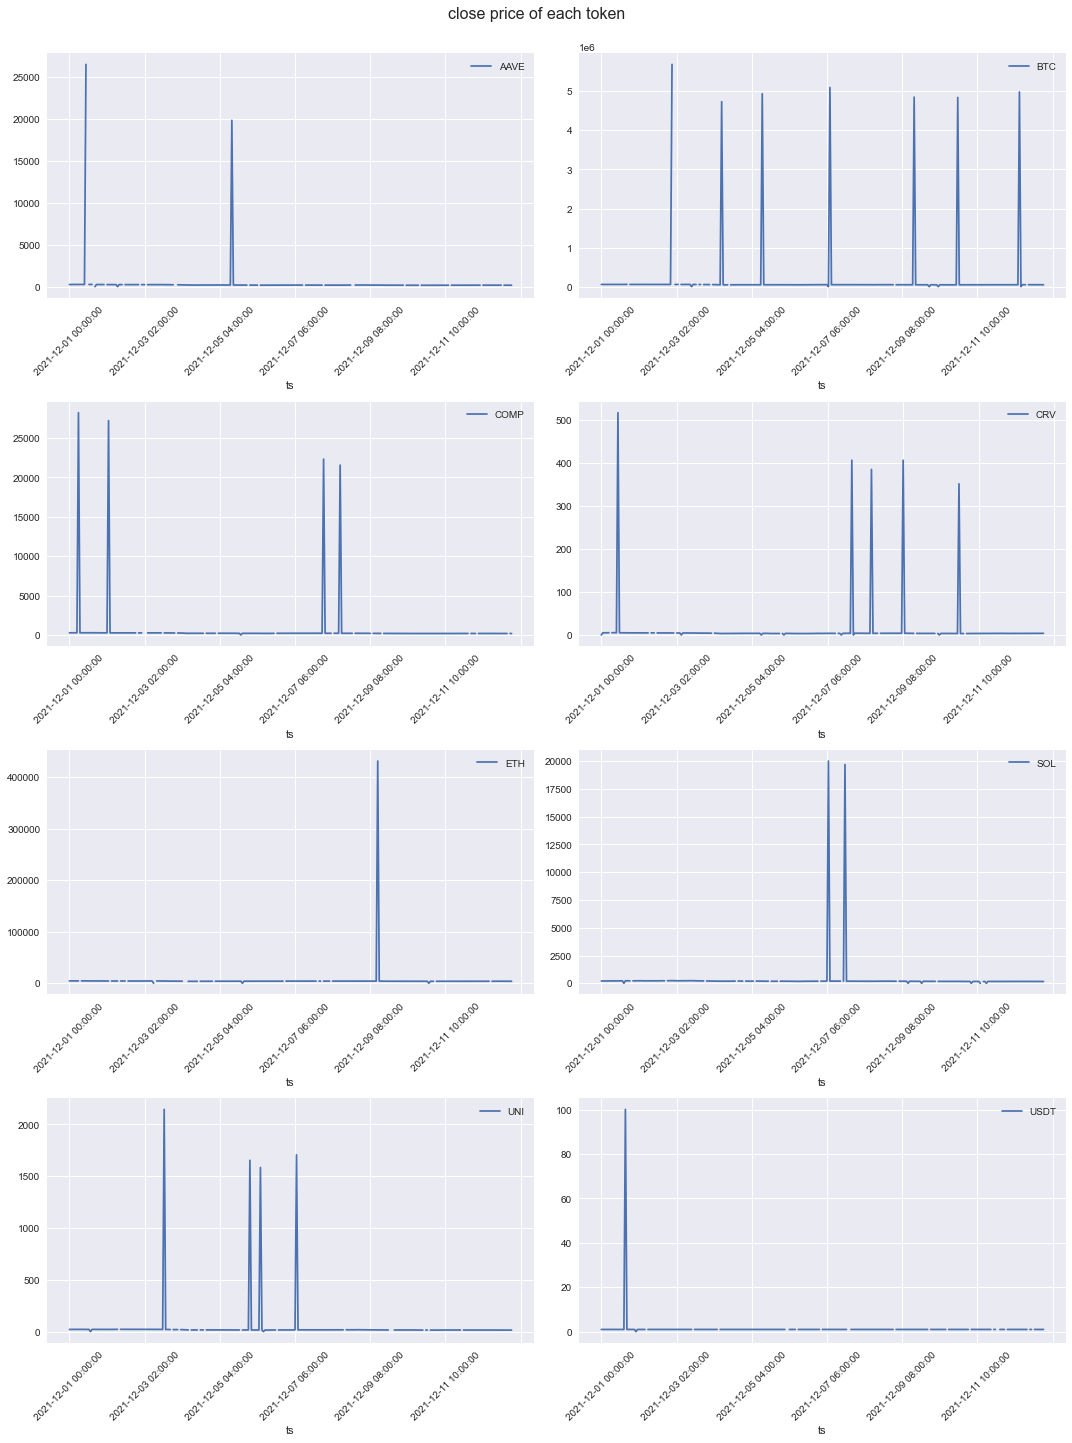

In [12]:
for price_name in ['open','high','low','close']:
    price_plotting(data_df, price_name)

As we can see from the figure, the open price is shown normally, while there are some outliers and missing values for other prices. So we assume that the open price is correct for all tokens. The outliers of other prices will be replaced as missing values and will be given reasonable values when the missing values are interpolated at next step.  
The judgement criteria for a outlier is its price value over open price is higher than 10 or lower than 0.1.

In [13]:
data_df[(data_df[['high','low','close']] / data_df.open.values.reshape(-1,1) > 10) |
       (data_df[['high','low','close']] / data_df.open.values.reshape(-1,1) < 0.1)] = np.nan

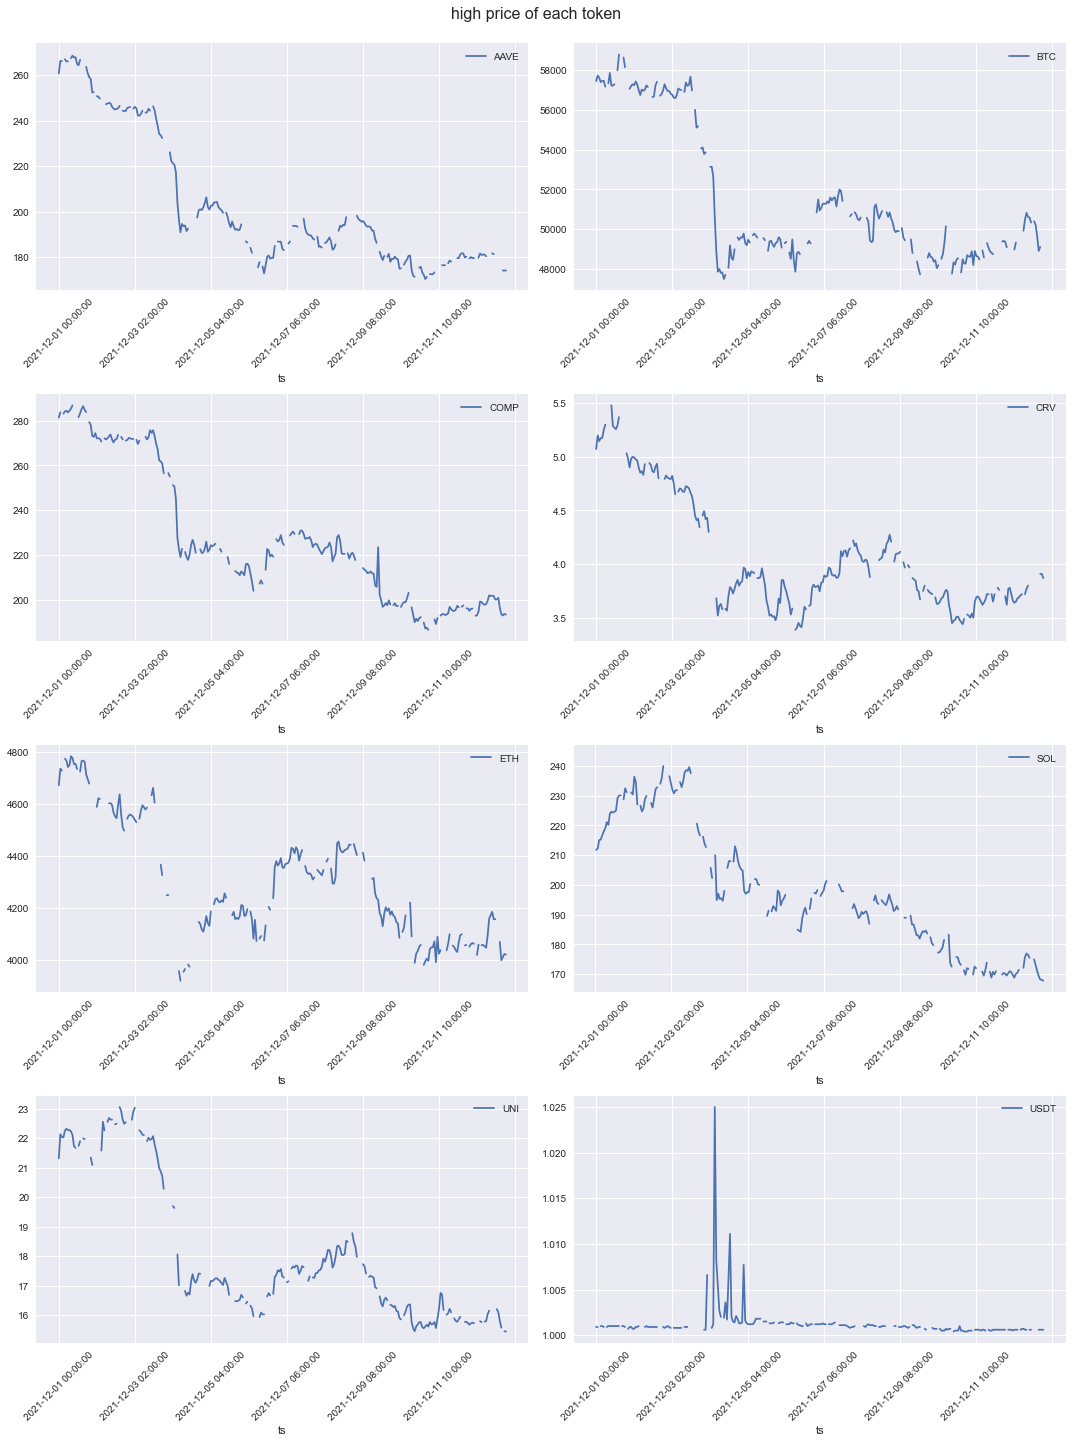

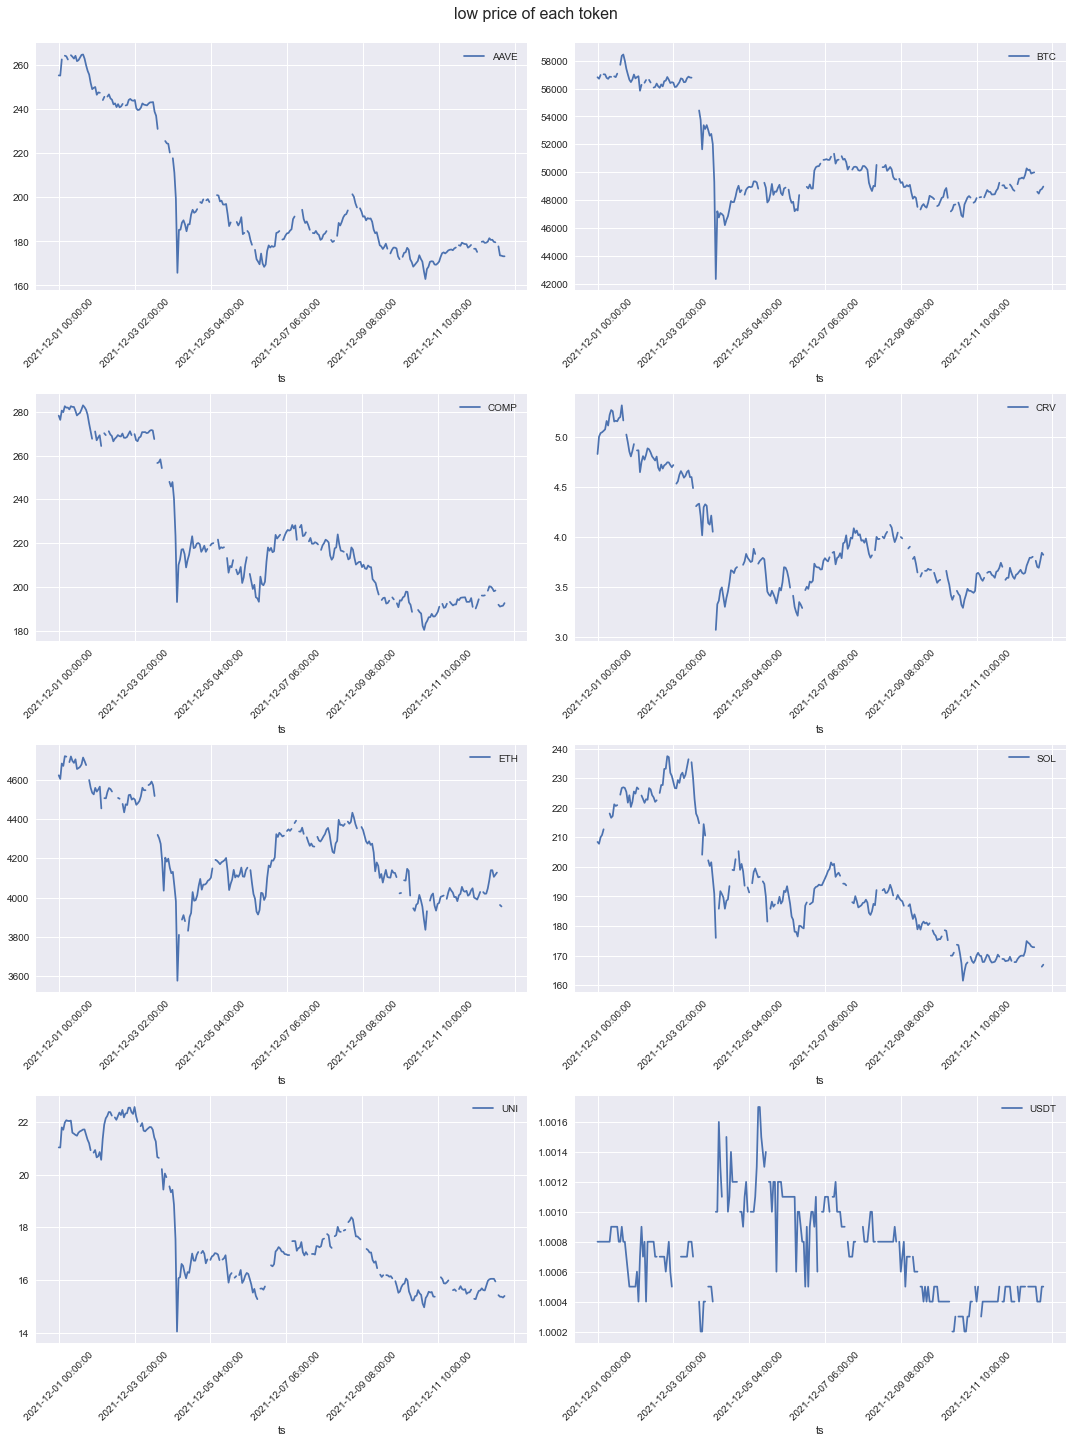

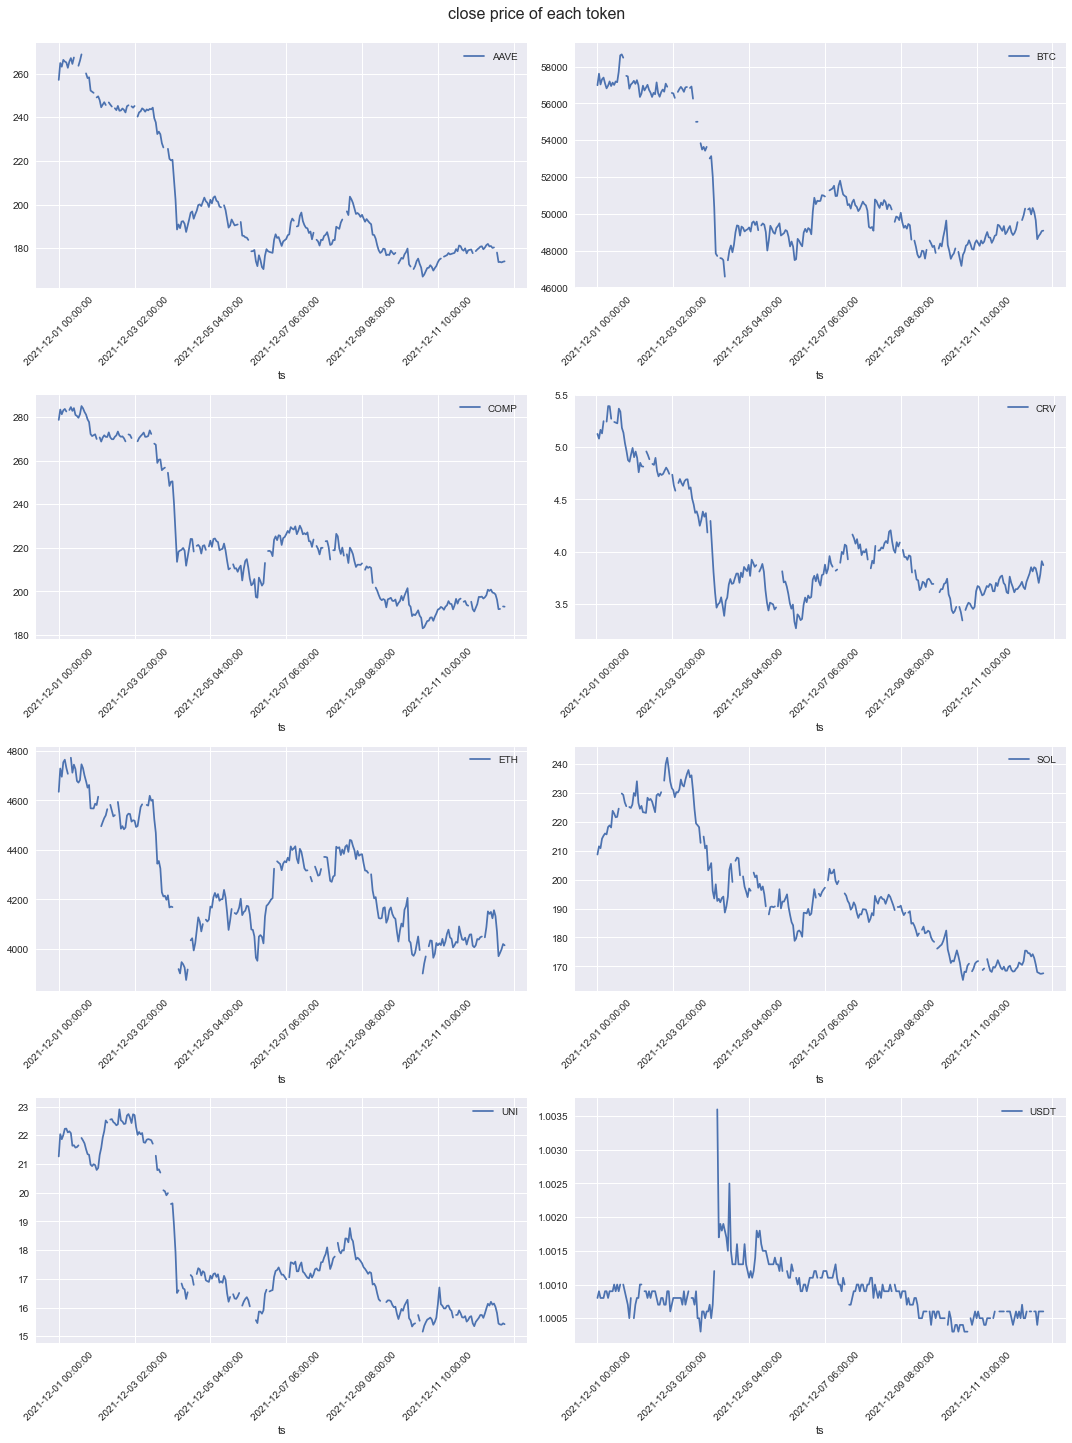

In [14]:
for price_name in ['high','low','close']:
    price_plotting(data_df, price_name)

## Fill missing data

In [15]:
data_df.isnull().sum()

ts              0
open            0
high          450
low           256
close         169
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

As we can see, `open` has no missing value. Assume the gap between the open price and other prices are steady for each token, we will fill other prices using this steady gap for each token.

In [16]:
def missing_price_filling(df, price_name):
    price_open_gap = df[price_name] - df['open']
    price_open_gap.interpolate(method='linear', limit_direction='both', inplace=True)
    missing_idx = df[price_name].isnull().values
    df.loc[missing_idx, price_name] = df.loc[missing_idx, 'open'] + price_open_gap.loc[missing_idx]
    return df

In [17]:
for price_name in ['high', 'low', 'close']:
    data_df = data_df.groupby('token').apply(missing_price_filling, price_name=price_name)

In [18]:
data_df.isnull().sum()

ts              0
open            0
high            0
low             0
close           0
volume          0
volumeUSD    2360
token           0
chain           0
dtype: int64

# Calculate `volumeUSD`

In [19]:
data_df['volumeUSD'] = data_df.volume * data_df.close

# Calculate volumeUSD by chain

In [20]:
volumeusd_by_chain = data_df.groupby('chain')[['volumeUSD']].sum()
volumeusd_by_chain.sort_values('volumeUSD', ascending=False, inplace=True)
volumeusd_by_chain

,volumeUSD
chain,
ETH,1.367203e+10
BTC,1.095665e+10
SOL,4.075018e+09
USDT,1.007837e+09


# Visualization

<AxesSubplot:title={'center':'VolumeUSD by Chain'}, xlabel='chain'>

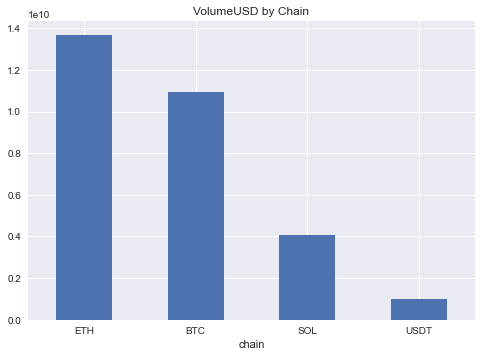

In [21]:
volumeusd_by_chain.plot(kind='bar', title='VolumeUSD by Chain', rot=0, legend=False)

The following shows the prices of each token:

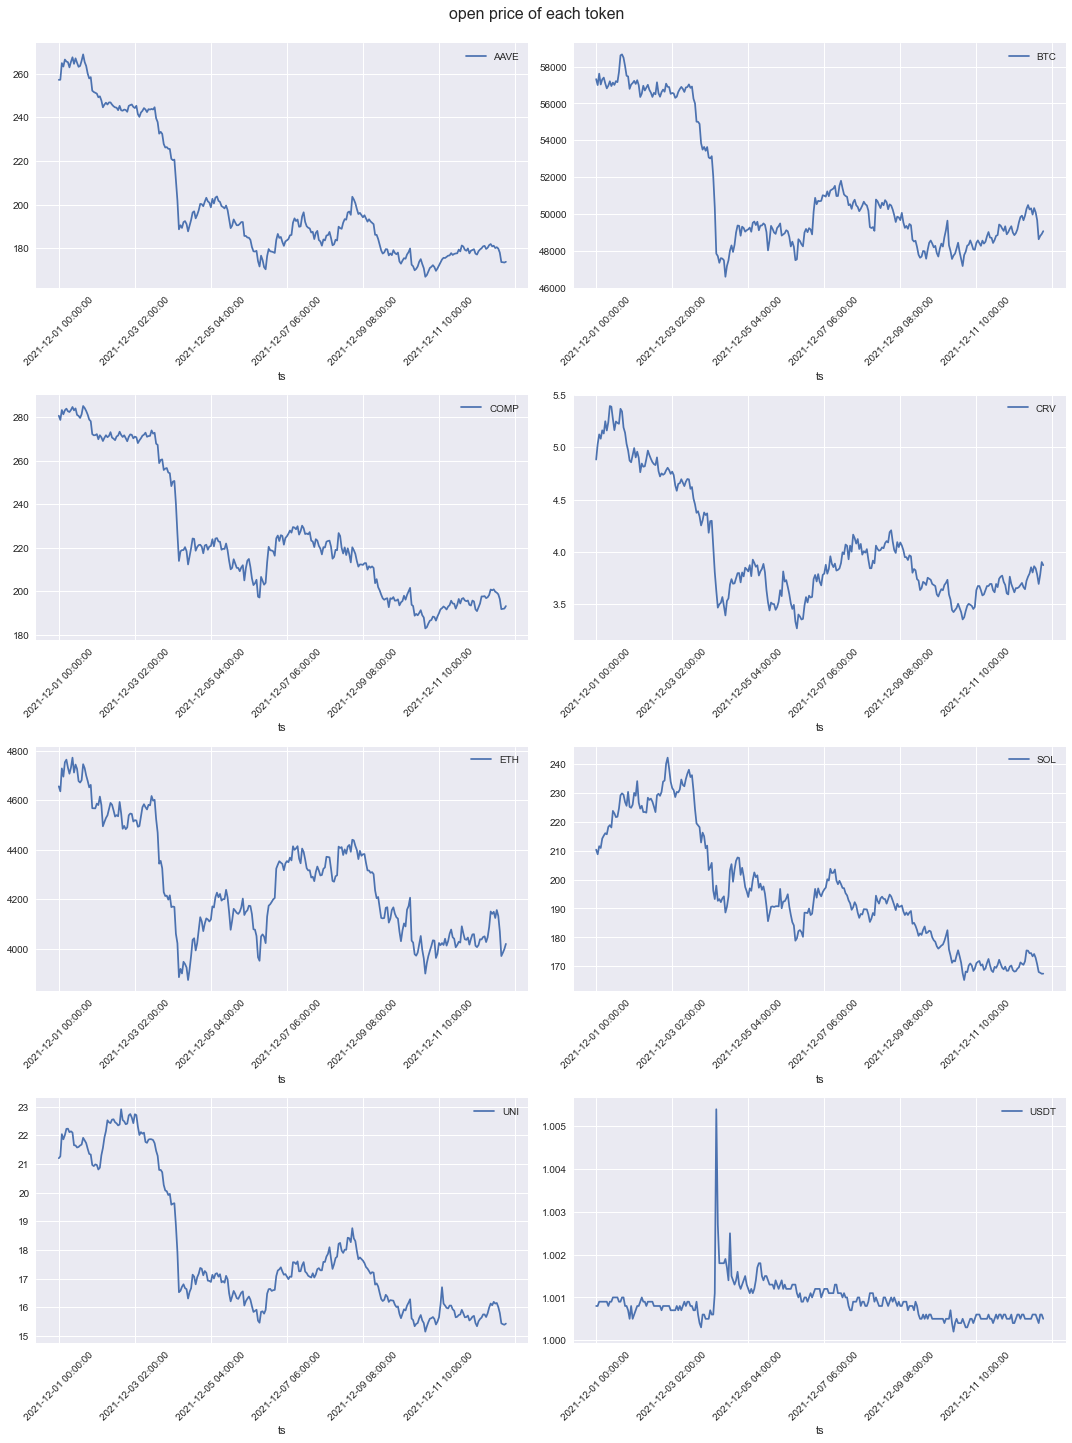

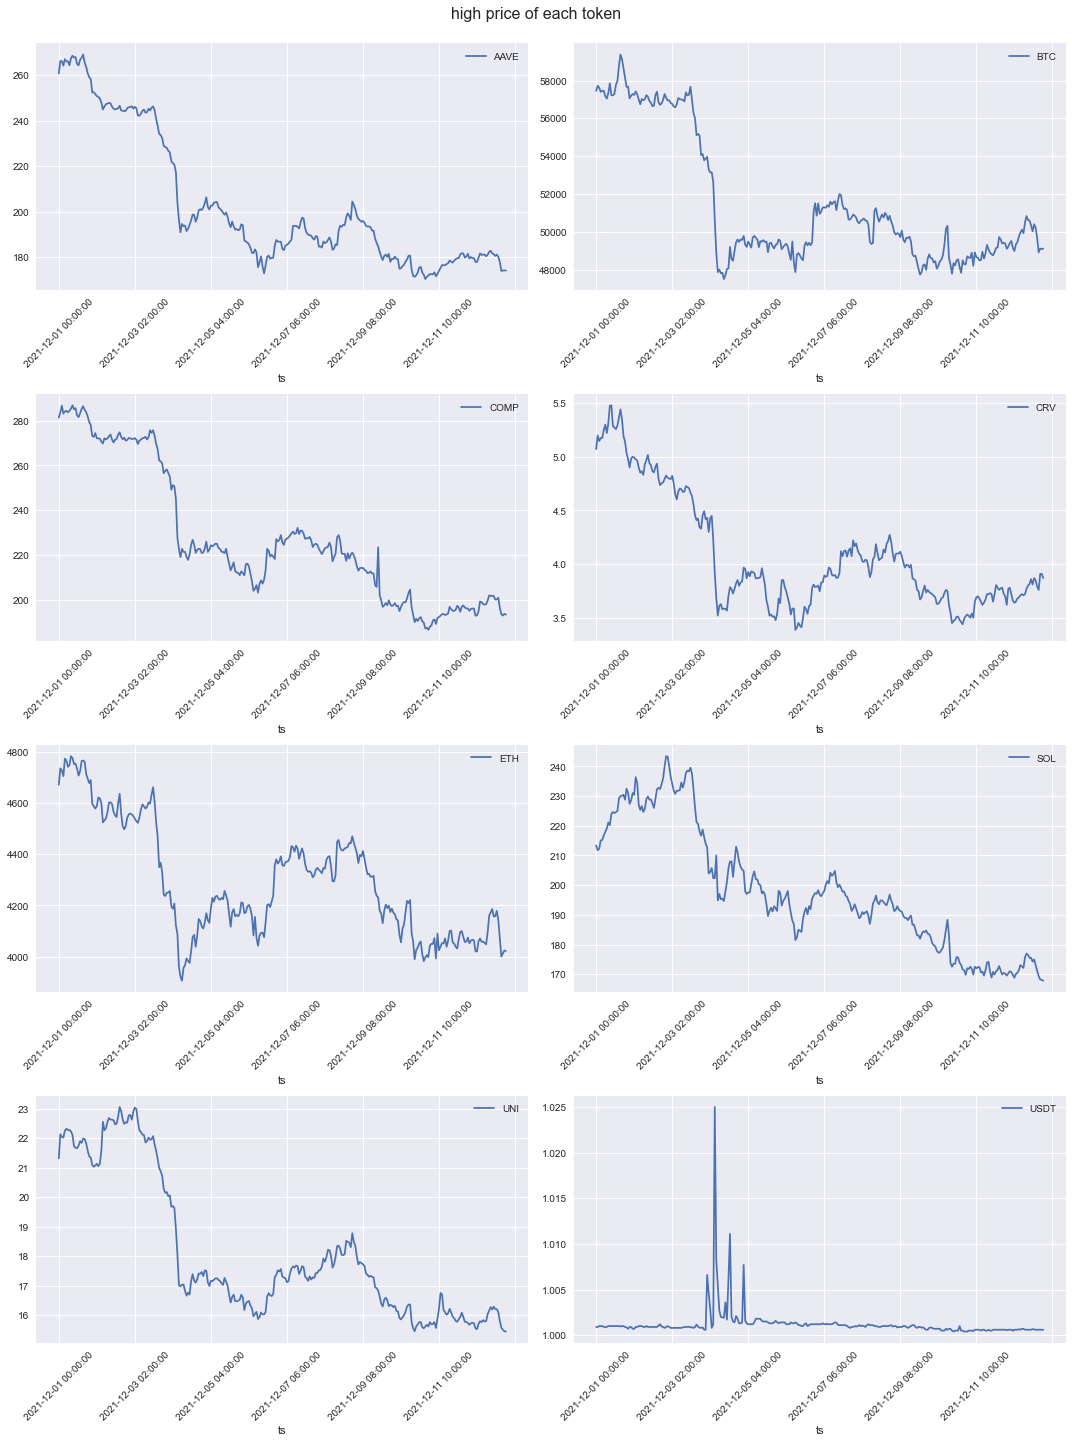

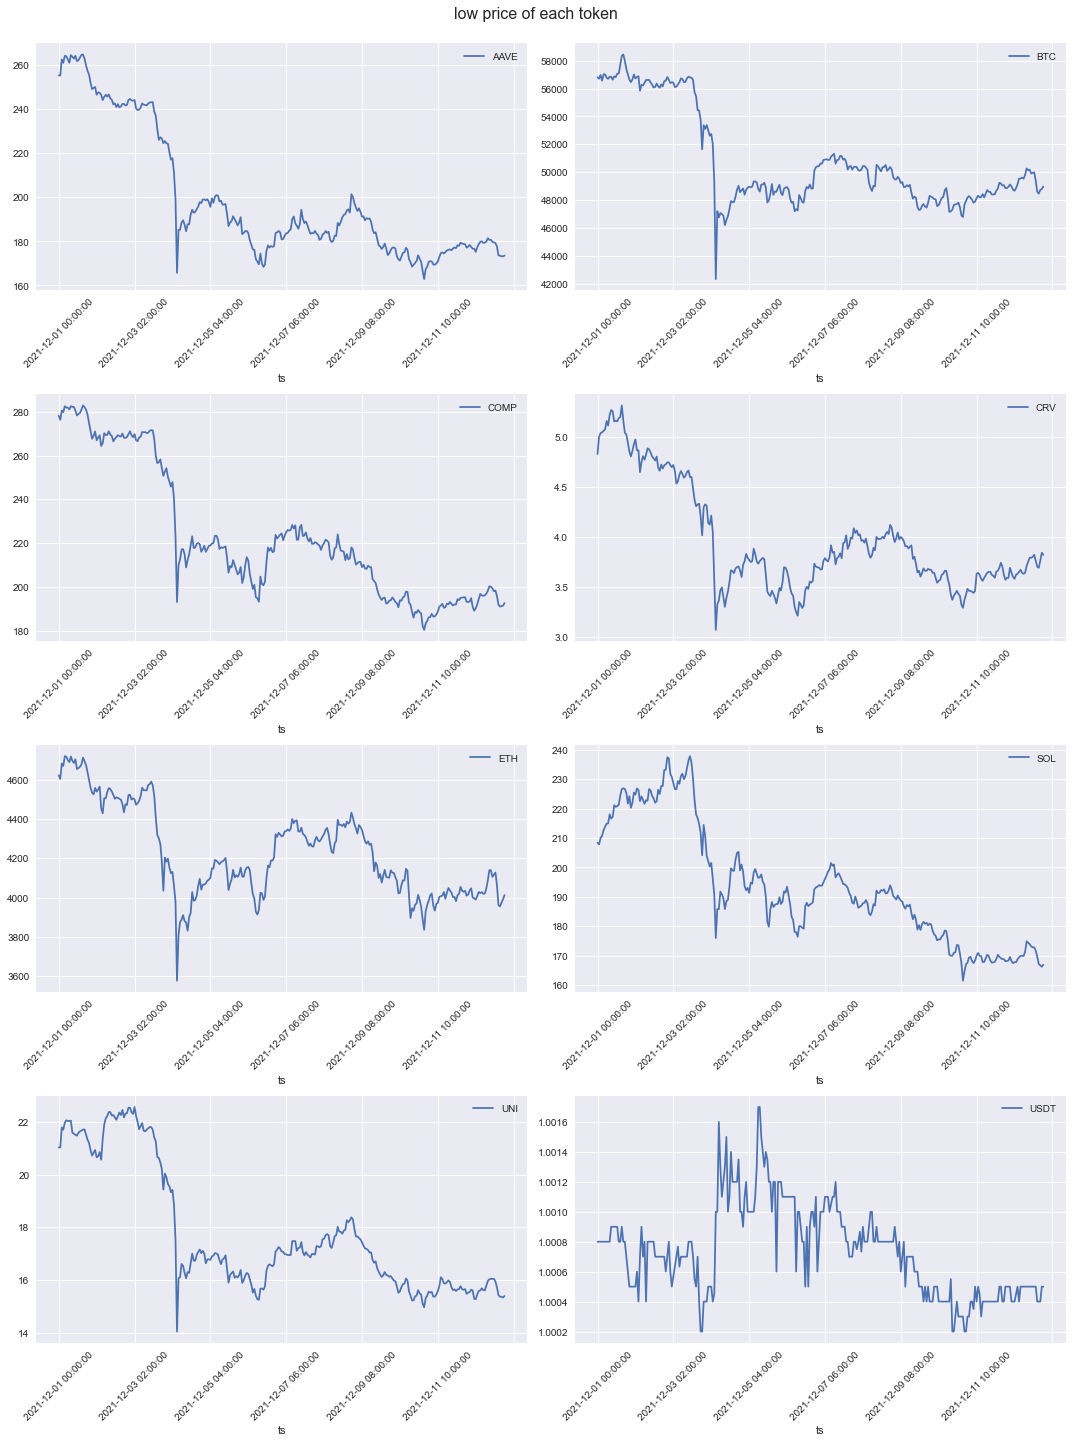

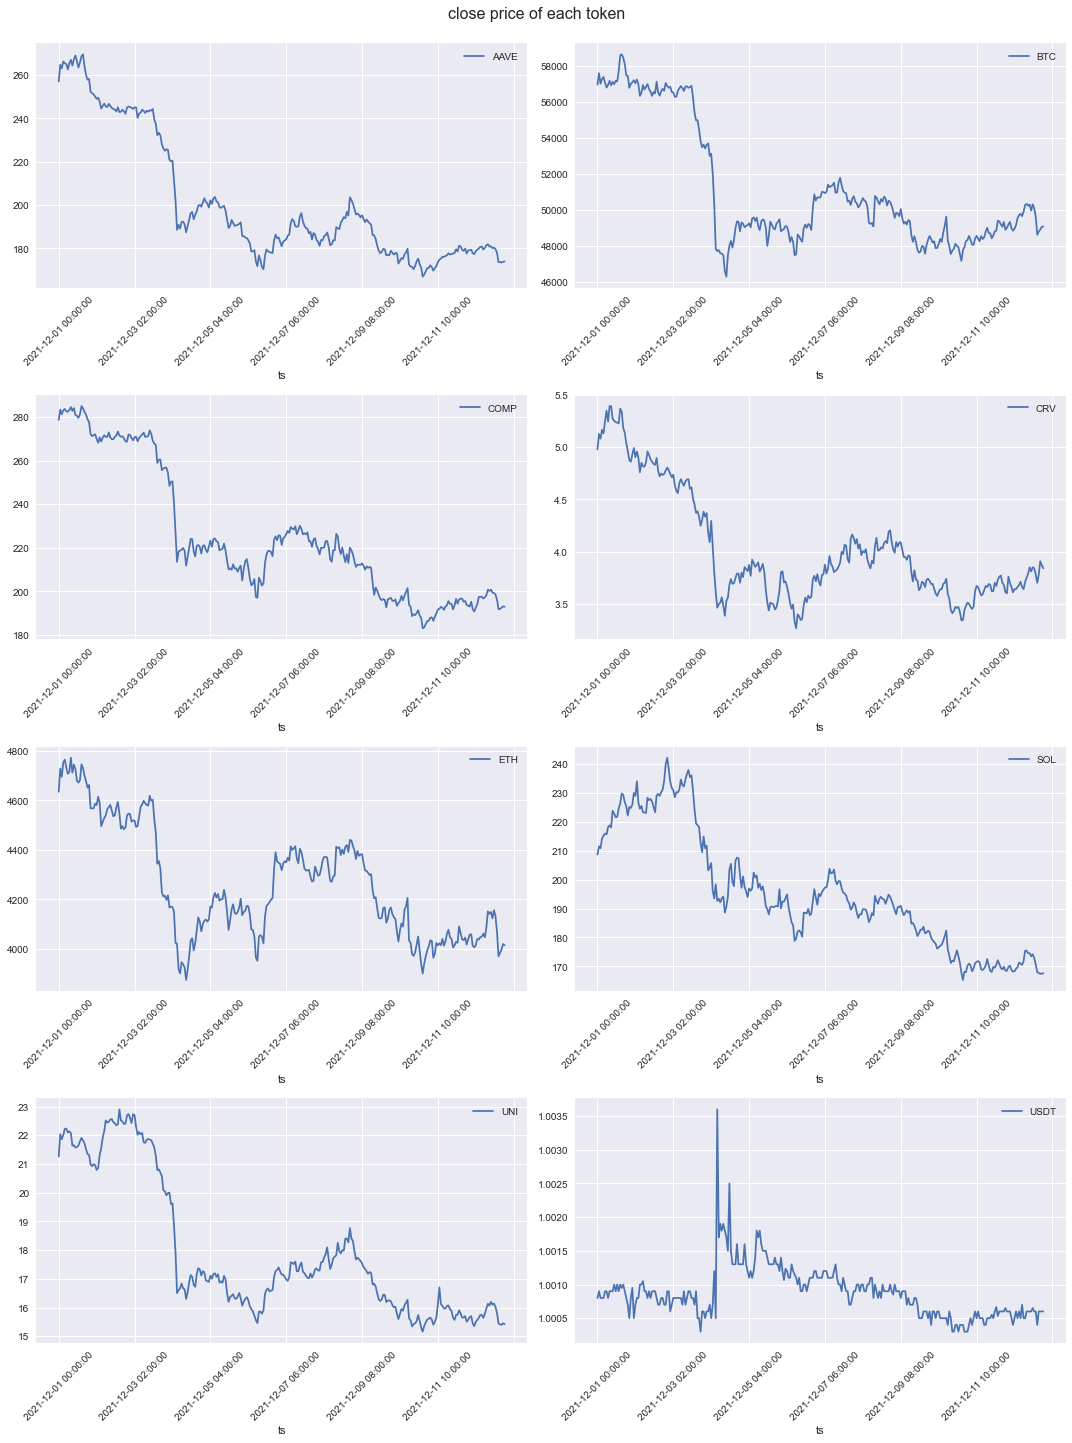

In [22]:
for price_name in ['open','high','low','close']:
    price_plotting(data_df, price_name)

All prices in one figure: 

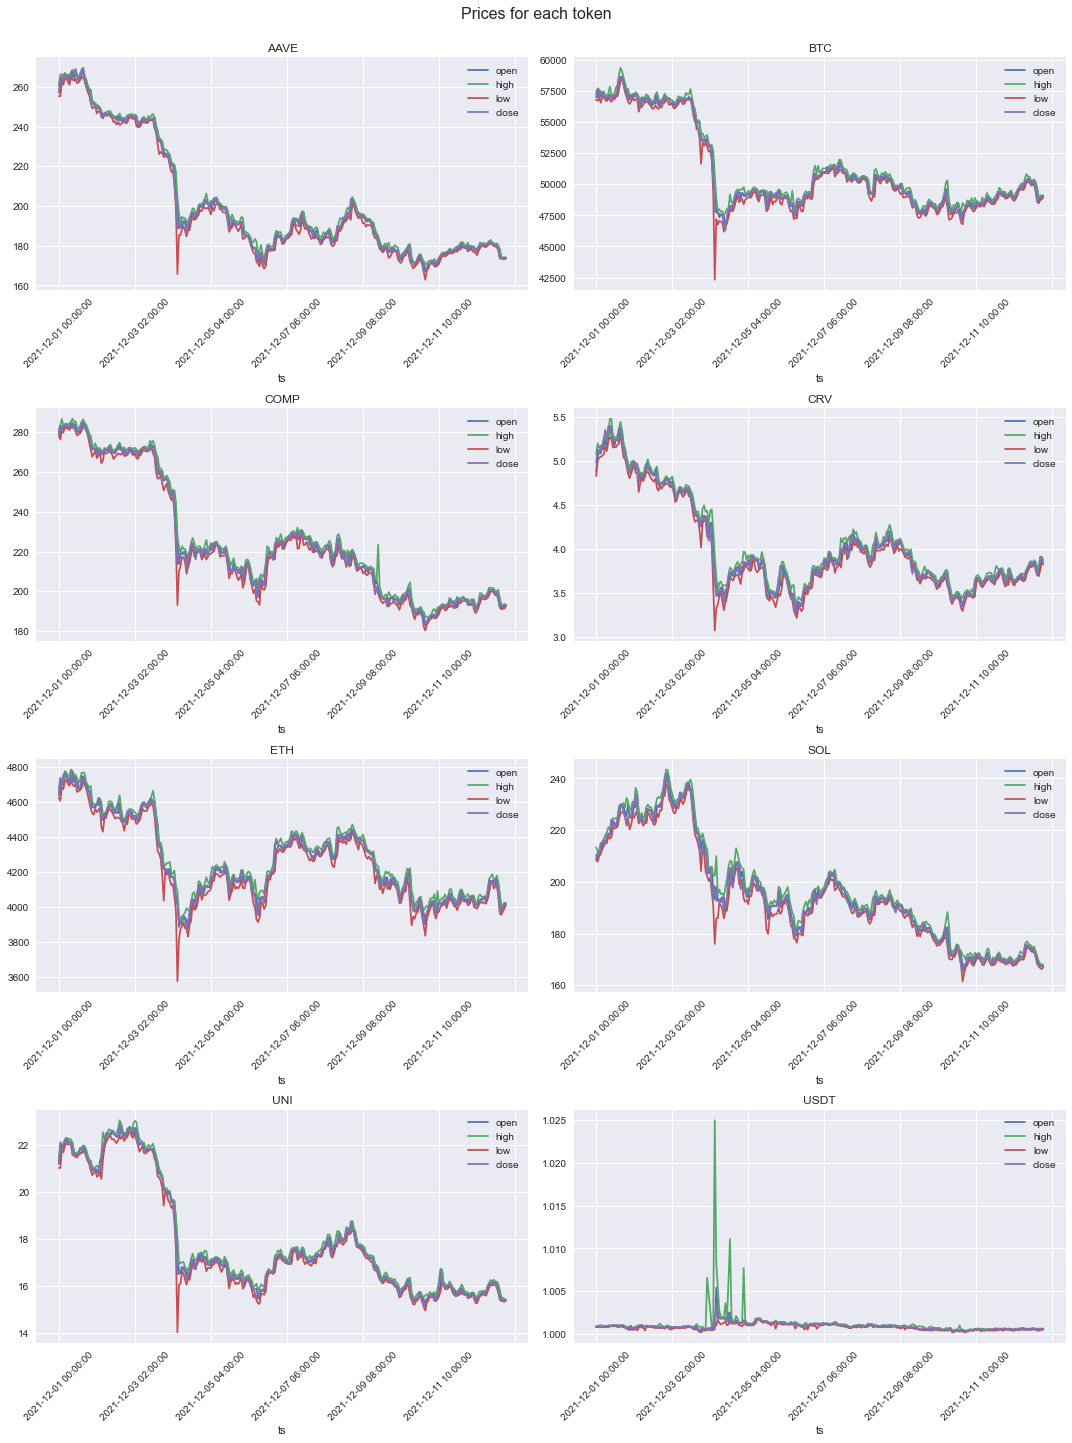

In [23]:
n_tokens = len(data_df.token.unique())

fig, axes = plt.subplots(nrows=math.ceil(n_tokens/2), ncols=2,
                         figsize=(15, 5*math.ceil(n_tokens/2)))

for i, (token, token_df) in enumerate(data_df[['ts','token','open','high','low','close']].groupby('token')):
    token_df.set_index('ts', inplace=True)
    token_df[['open','high','low','close']].plot(ax=axes[i//2, i%2], rot=45, title=token)

plt.suptitle('Prices for each token', fontsize=16, y=1)
plt.tight_layout()